In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
import scipy.linalg as la

import openmodes
from openmodes.material import IsotropicMaterial
from openmodes.operator.penetrable import PMCHWTOperator, CTFOperator
from openmodes.sources import PlaneWaveSource
from openmodes.basis import DivRwgBasis, LoopStarBasis
from openmodes.constants import eta_0, c
from openmodes.integration import RectangularContour, EllipticalContour, ExternalModeContour, DunavantRule, GaussLegendreRule
from openmodes.model import ModelSplit, ModelMutualWeight

In [2]:
savefigs = False

savepath = "."
extension = ".pdf"

def savefigure(filename):
    if savefigs:
        plt.savefig(osp.join(savepath, filename+extension), dpi=600)

In [3]:
sim = openmodes.Simulation(operator_class=PMCHWTOperator, notebook=True)

parameters={'radius':242e-9, 'height':220e-9, 'mesh_tol':50e-9, 'rounding':50e-9, 'hole_radius': 121e-9}

In [4]:
def eps_si_green(s):
    """Permittivity of Silicon, fitting to Green and Keevers 1995
    
    Fitted with 4 poles, plus their conjugates and a constant background term in the range 300-1200THz (1μm-0.25μm)
    """
    s = np.atleast_1d(s)
    omega = s/1j

    # pole frequency
    omega_0 = 2*np.pi*1e12*np.array([1354.23, 1033.91, 813.865, 910.585])
    # Q factor
    Q = np.array([5.324, 9.18531, 14.1796, 4.07376])
    # zero frequency
    omega_z = 2*np.pi*1e12*np.array([-2035.59, -8179.2, 901.107, 3119.69])
    # static/partial fraction gain
    gain = np.array([1.3332, 3.29269, 1.33682, 4.28297])

    # permittivity background
    eps_inf = 1.46505

    # delta_0 = omega_0**2

    delta_1 = omega_0/Q
    gamma_0 = gain*omega_0**2
    gamma_1 = gamma_0/omega_z
    
    return np.sum((gamma_0[:, None]+1j*omega*gamma_1[:, None])/
                  (omega_0[:, None]**2 + 1j*omega*delta_1[:, None] - omega**2), axis=0) + eps_inf


material = IsotropicMaterial("Silicon", eps_si_green, 1)


In [5]:
mesh = sim.load_mesh(osp.join(openmodes.geometry_dir, "cylinder_hole.geo"), parameters=parameters)
part = sim.place_part(mesh, material=material)

In [6]:
cross_section = 2*np.pi*parameters['radius']**2

In [7]:
pw = PlaneWaveSource([0, 1, 0], [0, 0, 1], p_inc=1.0)

num_freqs = 200
freqs = np.linspace(100e12, 450e12, num_freqs)

In [8]:
extinction = np.empty(num_freqs, np.complex128)

for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    Z = sim.impedance(s)
    V = sim.source_vector(pw, s)
    I = Z.solve(V)
    V_E = sim.source_vector(pw, s, extinction_field=True)
    extinction[freq_count] = np.vdot(V_E, I)
    

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


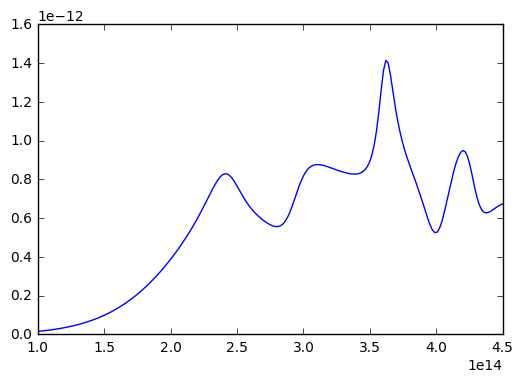

In [9]:
plt.figure()
plt.plot(freqs, extinction.real)
plt.show()

In [10]:
contour = ExternalModeContour(-8e14+2j*np.pi*450e12, avoid_origin=3e14, overlap_axes=1e11,
                             integration_rule=GaussLegendreRule(80))

estimates = sim.estimate_poles(contour)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [11]:
s_out = list(estimates.modes_of_parts.values())[0]['s_out']

contour_points = np.array([p for p, w in contour])


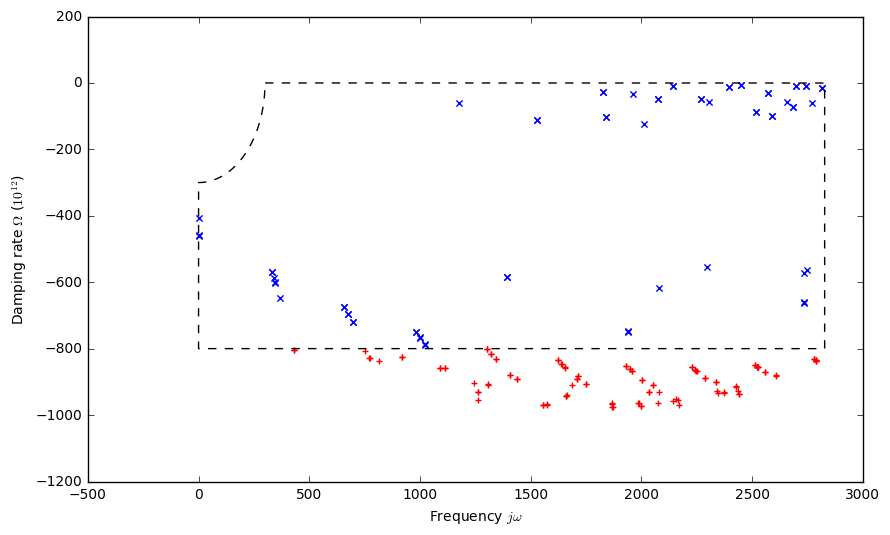

In [12]:
fig = plt.figure(figsize=(10, 6))
points = plt.scatter(estimates.s.imag*1e-12, estimates.s.real*1e-12, marker='x')
plt.scatter(s_out.imag*1e-12, s_out.real*1e-12, marker='+', color='red')
plt.plot(contour_points.imag*1e-12, contour_points.real*1e-12, 'k--')

plt.xlabel('Frequency $j\omega$')
plt.ylabel('Damping rate $\Omega$ ($10^{12}$)')

plt.show()

In [13]:
refined = sim.refine_poles(estimates, max_iter=10)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [14]:
full_modes = refined.add_conjugates()

model = ModelMutualWeight(full_modes)

## Calculate extinction by modes

In [15]:
num_modes = len(model.modes)
extinction_modes = np.empty((num_freqs, num_modes), np.complex128)

vr = model.vr
vl = model.vl

for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    V = sim.source_vector(pw, s)
    V_E = sim.source_vector(pw, s, extinction_field=True)
    
    I_modes = model.impedance(s).solve(vl.dot(V))
    extinction_modes[freq_count] = V_E.vdot(vr*I_modes)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## Plot calculated extinction
Comparing extinction from all modes, with direct calculation

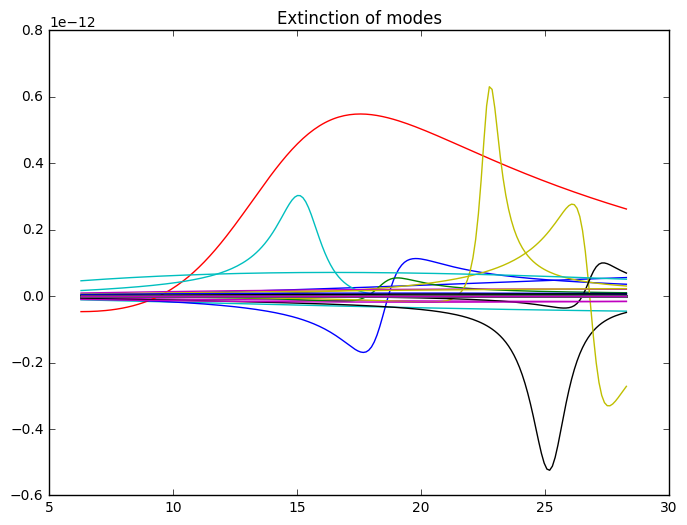

In [16]:
fig = plt.figure(figsize=(8, 6))
lines = plt.plot(freqs*1e-14*2*np.pi, extinction_modes.real)
plt.title('Extinction of modes')
plt.show()

In [17]:
def group_modes(modes, threshold=1e-2):
    "Group all modes which are degenerate, and which are complex conjugates of each other, within a certain threshold"

    # determine matching for each unique part id
    matched = {}
    for part_id, part_data in modes.modes_of_parts.items():
        s = part_data['s']
        s = s.real + 1j*np.abs(s.imag) # normalise so that conjugate modes get included
        matched[part_id] = []
        unmatched = list(range(len(s)))

        while len(unmatched) > 0:
            current = unmatched.pop()
            ds = np.abs((s[current]-s[unmatched])/s[current])
            matches = np.where(ds < threshold)[0]
            current_group = [current]
            # Traverse in reverse order so that popping does not invalidate other
            # elements
            for m in reversed(matches):
                current_group.append(unmatched[m])
                unmatched.pop(m)
            matched[part_id].append(current_group)
            
    # turn this into a list of mode numbers
    return matched

In [18]:
grouped_modes = list(group_modes(full_modes, 5e-3).values())[0]
extinction_degen = np.zeros((len(freqs), len(grouped_modes)), np.complex128)

for match_num, match in enumerate(grouped_modes):
    for mode in match:
        extinction_degen[:, match_num] += extinction_modes[:, mode]

significant_groups = np.max(np.abs(extinction_degen.real), axis=0) > 0.2e-12

wanted_modes = []
unwanted_modes = []
wanted_groups = []
import bisect

wanted_extinction = []

for match_num, match in enumerate(grouped_modes):
    if significant_groups[match_num]:
        mode_num = min(match)
        position = bisect.bisect(wanted_modes, mode_num)
        wanted_modes.insert(position, mode_num)
        wanted_groups.insert(position, match)
        wanted_extinction.insert(position, extinction_degen[:, match_num])
    else:
        for mode_num in match:
            # find one mode, with positive imaginary part
            if full_modes.s[:, mode_num].imag > 0:
                unwanted_modes.append(mode_num)
                break

wanted_extinction = np.array(wanted_extinction).T

In [19]:
print(wanted_groups)
print(wanted_modes)

[[87, 86, 23, 22], [89, 88, 25, 24], [104, 103, 40, 39], [112, 111, 48, 47], [119, 118, 55, 54]]
[22, 24, 39, 47, 54]


In [54]:
vars_to_save = ['wanted_groups', 'wanted_extinction', 'freqs', 'refined', 'extinction_modes',
                'parameters', 'extinction', 'unwanted_modes', 'wanted_modes', 'sim', 'full_modes']

results = dict((var, globals()[var]) for var in vars_to_save)

In [55]:
import dill as pickle

with open("holey-disk.pickle", "wb") as outfile:
    pickle.dump(results, outfile)

In [66]:
mode = wanted_groups[0][1]
sim.plot_3d(solution=full_modes.vr["J", :, 'modes', mode])